# Gaussian Process Regression

This notebook fits a Gaussian Process model to a noisy training dataset.

In [1]:
from jax import config

# Double precision is highly recommended.
config.update("jax_enable_x64", True)

from jax import jit
from jax import lax
from jax import nn
from jax import numpy as jnp
from jax import random
from jax import scipy
from jax import value_and_grad
from jax import vmap

import optax
import matplotlib.pyplot as plt

from boax.prediction import kernels, means, processes

## Dataset

For our synthetic training dataset we first draw random samples from a uniform distribution and then generate noisy observations by applying the objective function and adding gaussian noise to it.

In [2]:
def objective(x):
    return jnp.sin(4 * x[..., 0]) + jnp.cos(2 * x[..., 0])

In [3]:
data_key, noise_key, sample_key = random.split(random.key(0), 3)
x_train = random.uniform(data_key, shape=(100, 1), minval=-3, maxval=3)
y_train = objective(x_train) + 0.3 * random.normal(noise_key, shape=(100,))

Next we plot the training data on top of latent objective function.

In [4]:
x_test = jnp.linspace(-3.5, 3.5, 351)[..., jnp.newaxis]
y_test = objective(x_test)

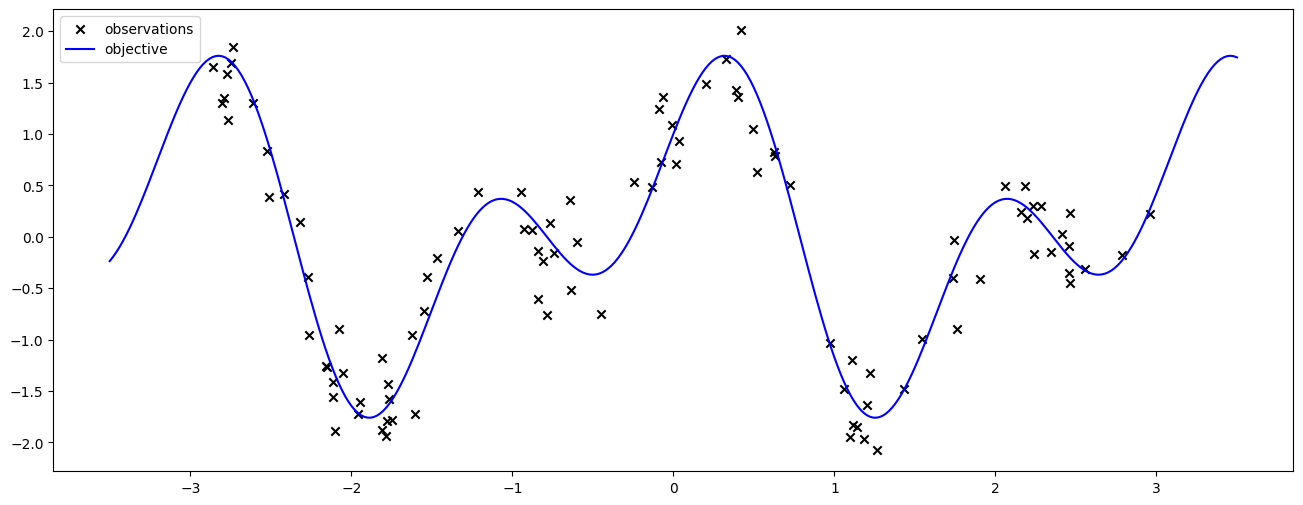

In [5]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.scatter(x_train, y_train, color='black', marker='x', label='observations')
ax.plot(x_test, y_test, color='blue', label='objective')
ax.legend()

plt.show()

## Fitting the gaussian process model

With the sythentic training dataset in place, we can move on to fitting a gaussian process model to the data. For that, we define a zero-mean gaussian process with a scaled RBF kernel. Note, we constrain the some of the models' hyperparameters `amplitude`, `length_scale`, and `noise` by the `softplus` function. This is crucial during training, as they are required to be positive.

In [6]:
def process(params):
    return processes.gaussian(
        means.zero(),
        kernels.scale(nn.softplus(params['amplitude']), kernels.rbf(nn.softplus(params['length_scale']))),
        nn.softplus(params['noise']),
    )

Next we initialise the parameters and plot our prior destribution over the test points.

In [7]:
params = {
    'amplitude': jnp.zeros(()),
    'length_scale': jnp.zeros(()),
    'noise': jnp.array(-5.),
}

In [8]:
prior_mean, prior_cov = process(params).prior(x_test)
prior_scale = jnp.sqrt(jnp.diag(prior_cov))

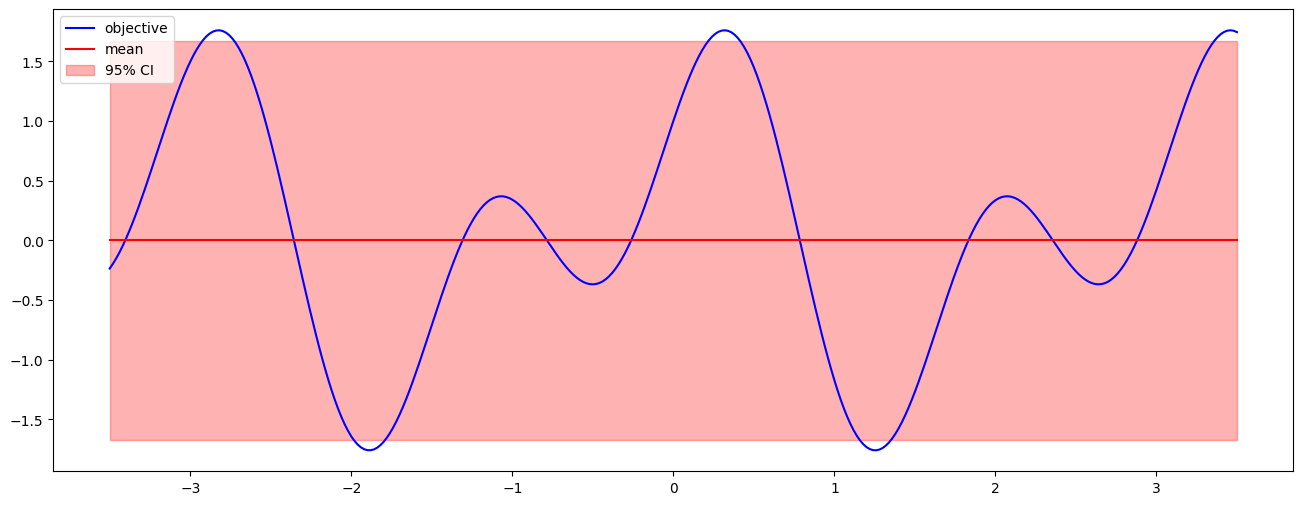

In [9]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(x_test, y_test, color='blue', label='objective')
ax.plot(x_test, prior_mean, color='red', label='mean')
ax.fill_between(x_test.flatten(), prior_mean - 2 * prior_scale, prior_mean + 2 * prior_scale, color='red', alpha=0.3, label='95% CI')
ax.legend()

plt.show()

To fit the parameters we use the Adam optimizer by minimizing the negative log likelihood on the training dataset.

In [10]:
optimizer = optax.adam(0.01)
opt_state = optimizer.init(params)

In [11]:
def train_step(state, iteration):
    def loss_fn(params):            
        loc, scale = process(params).prior(x_train)
        return -scipy.stats.multivariate_normal.logpdf(y_train, loc, scale)

    loss, grads = value_and_grad(loss_fn)(state[0])
    updates, opt_state = optimizer.update(grads, state[1])
    params = optax.apply_updates(state[0], updates)
    
    return (params, opt_state), loss

In [12]:
(next_params, next_opt_state), history = lax.scan(
    jit(train_step),
    (params, opt_state),
    jnp.arange(500)
)

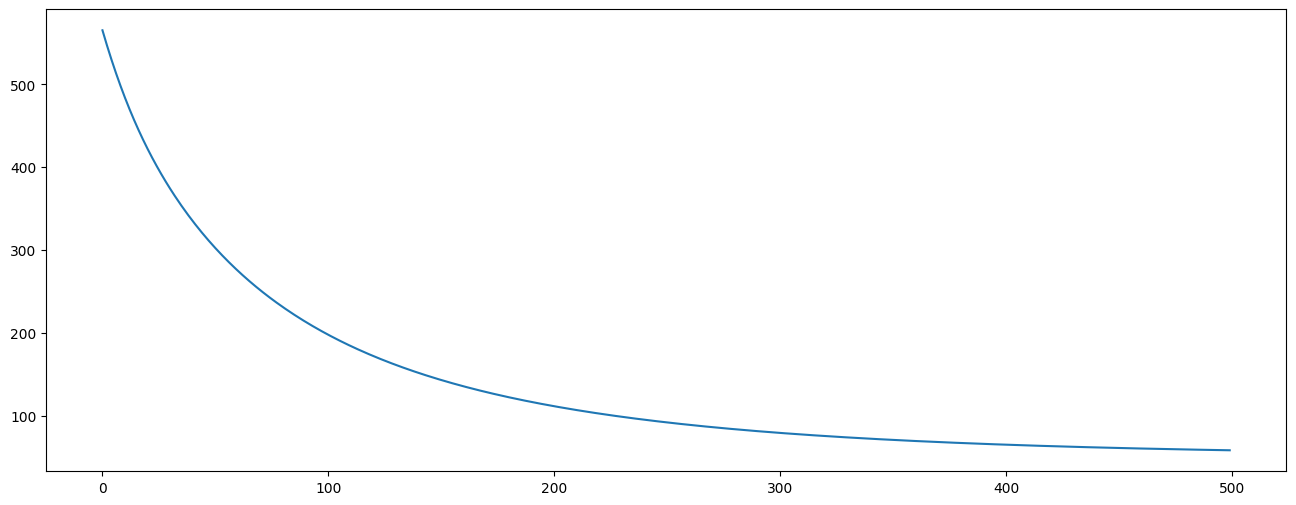

In [13]:
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(history, label='Negative Log Likelihood')

plt.show()

## Prediction

As the final step construct the posterior distribution by conditioning the prior on the training data and plot its mean and confidence interval as well as some samples against the noisy training data and ground truth latent function.

In [14]:
posterior_mean, posterior_cov = process(next_params).posterior(x_test, x_train, y_train)
posterior_scale = jnp.sqrt(jnp.diag(posterior_cov))
posterior_samples = random.multivariate_normal(sample_key, posterior_mean, posterior_cov, shape=(20,)).T

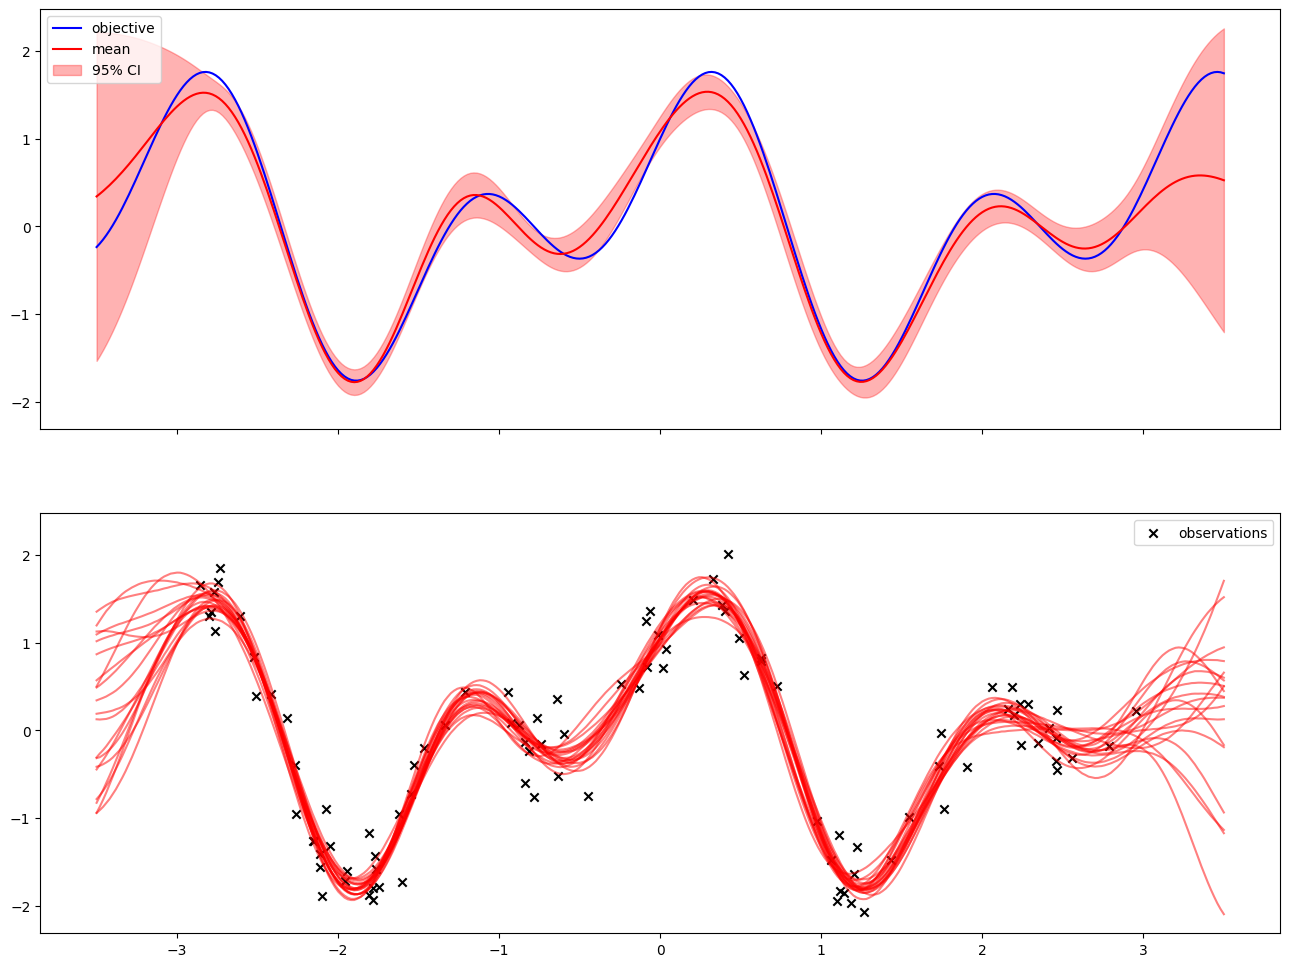

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(16, 12), sharex=True, sharey=True)

axs[0].plot(x_test, y_test, color='blue', label='objective')
axs[0].plot(x_test, posterior_mean, color='red', label='mean')
axs[0].fill_between(x_test.flatten(), posterior_mean - 2 * posterior_scale, posterior_mean + 2 * posterior_scale, color='red', alpha=0.3, label='95% CI')
axs[0].legend()

axs[1].scatter(x_train, y_train, color='black', marker='x', label='observations')
axs[1].plot(x_test, posterior_samples, color='red', alpha=0.5)
axs[1].legend()

plt.show()